**University of Science and Technology UST,  Zewail City**<br>
**CIE Program**<br>
**Computer Vision - CIE 552**<br>
**Lab Assignment #4 - Interpolation**<br>

**Student Name:** Elsayed Mohammed Elsayed Mostafa <br>
**Student ID:**   201700316

## Imports

In [ ]:
import numpy as np
import math
import cv2 
%matplotlib inline
from matplotlib import pyplot as plt

## Helper Functions

In [ ]:
def create_sharp_img():
    
    ksize = 7
    
    test_img = np.zeros((ksize,ksize))
    #1-D to 3-D:
    test_img = np.dstack([test_img,test_img,test_img])

    test_img[1,1,0]= 1.0
    test_img[1,5,1]= 1.0
    test_img[ksize//2,ksize//2,:] = 1.0
    test_img[5,5,2] = 1.0
    test_img[5,1,1] = 1.0
    test_img[5,1,0] = 1.0
    
    
    #float to np.uint8
    test_img = test_img/np.max(test_img)
    test_img = test_img*255
    test_img = test_img.astype(np.uint8)

    
    return test_img

In [ ]:
def create_gaussian_filter(ksize, sigma=(1,1)):
    '''''
    - A functions creates a gaussian filter of an arbitary size (ksize*ksize)
    @Parameters: 
        ksize: odd integer that represents the length and width of the mean filter
        sigma: a tuble/list of 2 elements represents (x_sigma, y_sigma), where sigma is the standard deviation of each direction
               However, the default value if 1 for both.
    @Returns:
        gaussian_filter: The obtained mean filter
    '''''
    assert ksize % 2 != 0
    
    # For the value of A, in case of sigma_x != sigma_y, I'll use the mean of both sigmas to evaluate the value of A
    A = 1/(2*np.pi*np.mean(sigma))
    # Creating a linspace for each direction (2D)
    x = np.linspace(start = 0, stop = ksize-1, num = ksize)
    y = x.copy()
    # Calculate the mean of each direction (One value as they're the same linspace)
    mu = np.mean(x)
    # Create the meshgrid that represents the 2D values as a grid
    X, Y = np.meshgrid(x,y)
    # Applying the gaussian filter equation on the created grid
    gaussian_filter = A * np.exp((-(X-mu)**2)/(2*sigma[0]) + (-(Y-mu)**2)/(2*sigma[1])) 
    return gaussian_filter

In [ ]:
def plot_3_imgs(img_list):
    fig = plt.figure(figsize=(20,10))

    plt.subplot(1, 3, 1)
    plt.imshow(img_list[0], cmap = 'gray')

    plt.subplot(1, 3, 2)
    plt.imshow(img_list[1])

    plt.subplot(1, 3, 3)
    plt.imshow(img_list[2])


    plt.show()

In [ ]:
def FullCubicInterp(p: list, x:float):
    #Uses Catmull-Rom spline
    a_interp = -0.5*p[0]  +  1.5*p[1] -  1.5*p[2] + 0.5*p[3]
    b_interp = p[0] -  2.5*p[1] + 2*p[2] - 0.5*p[3]
    c_interp = -0.5*p[0]  + 0.5*p[2]
    d_interp = p[1]
    
    return a_interp*(x**3) + b_interp*(x**2) + c_interp*(x) + d_interp

# Source: * https://www.paulinternet.nl/?page=bicubic , beware, cubicInterpolate function is faulty, use the one here.

In [ ]:
def GetPixelValue(imArr: np.ndarray, posX: np.float64, posY: np.float64, method : str = 'CUBIC', verbose: bool = False):
    '''
    :function: Get the pixel value at the position given using the interpolation method given.
    NB: The output is rounded as an integer since this function works on images. So, the function will not work on float values.
    
    
    :param imArr: original image array, dtype must be np.uint8
    
    :param posX : X position of the point(dtype:float) needed. This is the X position of the T_inv(T(pixel[x])). Where T_inv and T are inverse
    transform and transform respectively.
    
    :param posY : Y position of the point(dtype:float) needed. This is the Y position of the T_inv(T(pixel[y])). Where T_inv and T are inverse
    transform and transform respectively.
    
    :param method : Type of interpolation method used.
    
    NB: T_inv(T(X)) != X due to rounding errors or due  to the fact that it may not be present (we are adding more pixels!)
    
    :return: value of pixel at T(pixel[x]),T(pixel[y])
    
    '''
    
    #Get integer and fractional parts of numbers 
        #(3- Make sure you account for edge cases (eg: negative indices, or indices that are outside the original source image))
    
    modXi = int(posX) #Shows x to the left of the point
    modYi = int(posY) #Show y above the point

    modXiPlusOneLim = min(modXi+1,imArr.shape[1]-1)
    modYiPlusOneLim = min(modYi+1,imArr.shape[0]-1)
    
    modXiMinusOneLim = max(modXi-1,0)
    modYiMinusOneLim = max(modYi-1,0)
    
    modXiPlusPlusOneLim = min(modXi+2,imArr.shape[1]-1)
    modYiPlusPlusOneLim = min(modYi+2,imArr.shape[0]-1)
    
    modXf = max(0 , posX - modXi)
    modYf = max(0 , posY - modYi)
    
    
    x_s = [modXi , modXiPlusOneLim]
    y_s = [modYi , modYiPlusOneLim]
    
    '''
        (modXi,modYi)-------------------(modXiPlusOneLim,modYi)
        |                                                |
        |                                                |
        |               (posX,posY)                      |
        |                                                |
        (modXi,modYiPlusOneLim)---------------------(modXiPlusOneLim,modYiPlusOneLim)
        
    '''
   
    
    
    if (method == "NEAREST"):

        nearest_x = sorted( x_s, key = lambda x: (x-posX)**2 ) [0] 
        nearest_y = sorted( y_s, key = lambda y: (y-posY)**2 ) [0]
        
        if (verbose): print(f' Of points : {points_list}\n. Point {(nearest_x,nearest_y)} is closest to {(posX, posY)}') 
        out = imArr[nearest_y,nearest_x,:]
        
    
    elif (method == "LINEAR"):
        out = []
        
        for chan in range(imArr.shape[2]):
            #Get surrouding four points:  
            bl = imArr[modYiPlusOneLim,modXi,chan] #bottom left
            br = imArr[modYiPlusOneLim,modXiPlusOneLim,chan] #bottom right
            
            tl = imArr[modYi,modXi,chan] #top left
            tr = imArr[modYi,modXiPlusOneLim,chan] #top right
                
                
            #Line-Fitting 
            
            #First Linear Fit: 
            b = (1-modXf)*bl+modXf*br #Bottom Line point
            t = (1-modXf)*tl+modXf*tr #Top Line point
           
            #Second Linear Fit: 
            pxf = modYf*b+(1-modYf)*t  #Actual Point
            out.append(int(np.round(pxf)))

        
    elif (method == "CUBIC"):
        
        out = []
        
        for chan in range(imArr.shape[2]):
                

                #Get surrouding 16 points: 
                
                p = np.ndarray((4,4), dtype = np.float64)
                
                '''
                p[0,0] -- p[0,1] ------------ p[0,2] -- p[0,3]
                    |        |                   |        |
                p[1,0] -- p[1,1] ------------ p[1,2] -- p[1,3]
                    |        |    (posX,posY)   |         |
                p[2,0] -- p[2,1] ------------ p[2,2] -- p[2,3]
                    |        |                   |         |
                p[3,0] -- p[3,1] ------------ p[3,2] -- p[3,3]

                '''
                p[0,0]= imArr[ modYiMinusOneLim, modXiMinusOneLim, chan]
                p[0,1]= imArr[ modYiMinusOneLim, modXi, chan]
                p[0,2]= imArr[ modYiMinusOneLim, modXiPlusOneLim, chan]
                p[0,3]= imArr[ modYiMinusOneLim, modXiPlusPlusOneLim, chan]

                p[1,0]= imArr[ modYi, modXiMinusOneLim, chan]
                p[1,1]= imArr[ modYi, modXi, chan]
                p[1,2]= imArr[ modYi, modXiPlusOneLim, chan]
                p[1,3]= imArr[ modYi, modXiPlusPlusOneLim, chan]

                p[2,0]= imArr[ modYiPlusOneLim, modXiMinusOneLim, chan]
                p[2,1]= imArr[ modYiPlusOneLim, modXi, chan]
                p[2,2]= imArr[ modYiPlusOneLim, modXiPlusOneLim, chan]
                p[2,3]= imArr[ modYiPlusOneLim, modXiPlusPlusOneLim, chan]

                p[3,0]= imArr[ modYiPlusPlusOneLim, modXiMinusOneLim, chan]
                p[3,1]= imArr[ modYiPlusPlusOneLim, modXi, chan]
                p[3,2]= imArr[ modYiPlusPlusOneLim, modXiPlusOneLim, chan]
                p[3,3]= imArr[ modYiPlusPlusOneLim, modXiPlusPlusOneLim, chan]


                
                #First Cubic Fit:
                p_cubic = [0.0, 0.0, 0.0, 0.0]
                p_cubic[0] = FullCubicInterp(list(p[0,:]), modXf)
                p_cubic[1] = FullCubicInterp(list(p[1,:]), modXf)
                p_cubic[2] = FullCubicInterp(list(p[2,:]), modXf)
                p_cubic[3] = FullCubicInterp(list(p[3,:]), modXf)
                
                
                #Second Cubic Fit: #TODO 02
                point = FullCubicInterp(p_cubic, modYf)
                
                
                #Append this channel value:
                out.append( np.clip(int(np.round(point)), 0, 255) ) #Do we need to clip in the bilinear mode ? No. Why ?
            
            
            
    else:
        raise ValueError('UNKNOWN INTERPOLATION METHOD REQUESTED')
 
        
    
    return out

## Testing

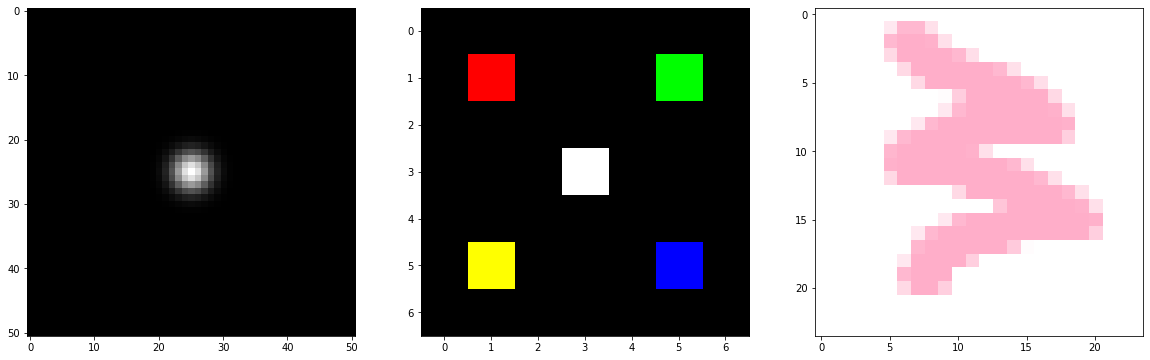

In [ ]:
smooth_test_img    = create_gaussian_filter(ksize = 51, sigma= (4.0,4.0))
smooth_test_img  = ((smooth_test_img/np.max(smooth_test_img))*255).astype(np.uint8)
smooth_test_img = np.dstack([smooth_test_img,smooth_test_img,smooth_test_img])

sharp_test_img     = create_sharp_img()

character_test_img = cv2.imread('Curve2.png')[:,:, ::-1] #[:,:, ::-1]  --> BGR to RGB


imgs_list = [smooth_test_img, sharp_test_img, character_test_img]

plot_3_imgs(imgs_list)

In [ ]:
#define the resizing ratio..
resize_ratio = 3

LINEAR


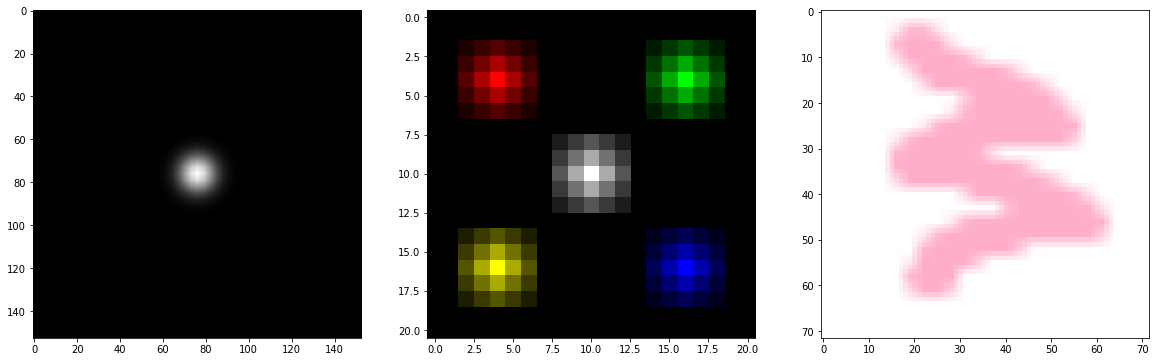

In [ ]:
#Bilinear Interpolation:
my_linear_resized_list = []
for test_img in imgs_list:

    im  = test_img
    #1 : Calculate the size of the new image give the transformation
    enlargedShape = ( int(np.round(im.shape[0]*resize_ratio)),
                      int(np.round(im.shape[1]*resize_ratio)),
                      im.shape[2]
                    )
    enlargedImg = np.empty(enlargedShape, dtype=np.uint8)  #Empty new image


    #Calculate the inverse transform 
    #(Note here that the inverse transform is calculated from the actual size, not from 1/resize_ratio)
    rowScale = float(im.shape[0]) / float(enlargedImg.shape[0])
    colScale = float(im.shape[1]) / float(enlargedImg.shape[1])


    #2- Loop over pixels in the the new -now empty- image and assign them one by one by:
    for r in range(enlargedImg.shape[0]):
        for c in range(enlargedImg.shape[1]):

            #Applying inverse transformation to the pixel postions from the new image:
            #3- Make sure you account for edge cases (eg: negative indices, or indices that are outside the original source image)
            orir = (r-(1/rowScale)//2) * rowScale #(r-resize_ratio/2) * rowScale #Find original row in original image
            oric = (c-(1/colScale)//2) * colScale #(c-resize_ratio/2) * colScale
            #Interpolating value for the inverse(new_pixel_position) from surrounding pixels in source image
            enlargedImg[r, c] = GetPixelValue(im, oric, orir, method = "LINEAR", verbose = False)

    my_linear_resized_list.append(enlargedImg)

print('LINEAR')
plot_3_imgs(my_linear_resized_list)



CUBIC


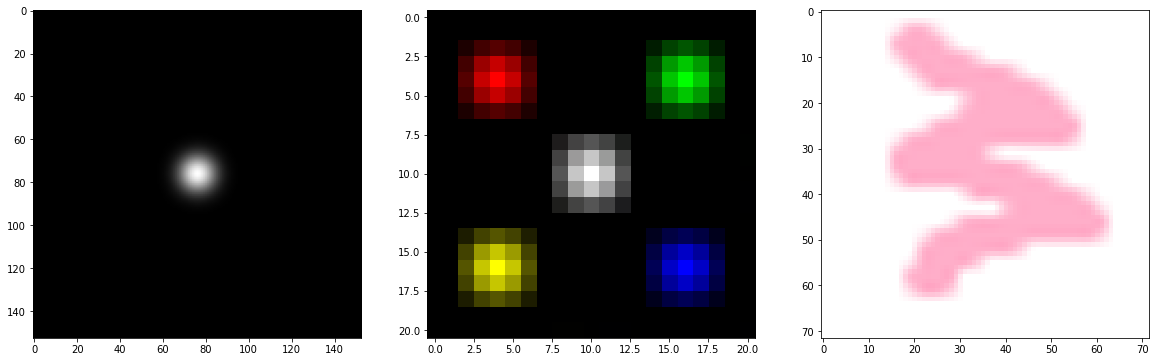

In [ ]:
#Bicbuic Interpolation:
my_cubic_resized_list = []
for test_img in imgs_list:

    im  = test_img
    #1 : Calculate the size of the new image give the transformation
    enlargedShape = ( int(np.round(im.shape[0]*resize_ratio)),
                      int(np.round(im.shape[1]*resize_ratio)),
                      im.shape[2]
                    )
    enlargedImg = np.empty(enlargedShape, dtype=np.uint8)  #Empty new image


    #Calculate the inverse transform 
    #(Note here that the inverse transform is calculated from the actual size, not from 1/resize_ratio)
    rowScale = float(im.shape[0]) / float(enlargedImg.shape[0])
    colScale = float(im.shape[1]) / float(enlargedImg.shape[1])


    #2- Loop over pixels in the the new -now empty- image and assign them one by one by:
    for r in range(enlargedImg.shape[0]):
        for c in range(enlargedImg.shape[1]):

            #Applying inverse transformation to the pixel postions from the new image:
            #3- Make sure you account for edge cases (eg: negative indices, or indices that are outside the original source image)
            orir = (r-(1/rowScale)//2) * rowScale #(r-resize_ratio/2) * rowScale #Find original row in original image
            oric = (c-(1/colScale)//2) * colScale #(c-resize_ratio/2) * colScale

            #Interpolating value for the inverse(new_pixel_position) from surrounding pixels in source image
            enlargedImg[r, c] = GetPixelValue(im, oric, orir, method = "CUBIC", verbose = False)

    my_cubic_resized_list.append(enlargedImg)

print('CUBIC')
plot_3_imgs(my_cubic_resized_list)


### OpenCV Cubic Interpolation

CUBIC


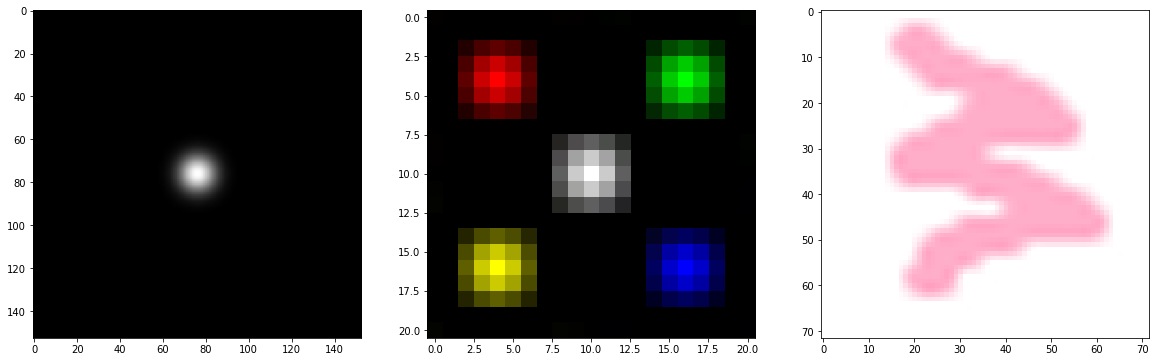

In [ ]:
#Bicubic Interpolation:
cubic_resized_list = []
for test_img in imgs_list:
    resized = cv2.resize(test_img, 
                         (int(test_img.shape[1]*resize_ratio) ,int(test_img.shape[0]*resize_ratio) ), interpolation = cv2.INTER_CUBIC)
    cubic_resized_list.append(resized)
    
print('CUBIC')
plot_3_imgs(cubic_resized_list)